In [1]:
import os
import jax

def setup_tpu(machine):
    # Allow splitting of multi chip TPU VM 3 into 4 machines, 2 cores per machine
    # https://gist.github.com/skye/f82ba45d2445bb19d53545538754f9a3
    os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,1,1"
    os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
    os.environ["TPU_VISIBLE_DEVICES"] = str(machine) # "0", .., "3"
    print(jax.devices())

def setup_cpu():
    #os.environ["JAX_PLATFORMS"]="cpu" 
    jax.config.update('jax_platform_name', 'cpu')
    print(jax.devices())

#setup_tpu(0)
#setup_cpu()

In [2]:
import jax
print(jax.devices())#

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]


In [3]:
# Silence WARNING:root:The use of `check_types` is deprecated and does not have any effect.
# https://github.com/tensorflow/probability/issues/1523
import logging
logger = logging.getLogger() 

class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from jaxtyping import Float, Array
from typing import Callable, NamedTuple, Union, Tuple, Any
from functools import partial
import chex
import optax
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import lax, jacfwd, vmap, grad, jit
from jax.tree_util import tree_map, tree_reduce
from jax.flatten_util import ravel_pytree

import flax
import flax.linen as nn
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
import haiku as hk

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from dataclasses import dataclass
from collections import namedtuple
from itertools import cycle



ModuleNotFoundError: No module named 'jaxtyping'

In [58]:

from rebayes.base import RebayesParams, Rebayes, Belief, make_rebayes_params

In [35]:

RebayesEstimator = namedtuple("RebayesEstimator", ["init", "predict_state", "update_state", "predict_obs", "update_params"])

def rebayes_scan(
        estimator,
        X: Float[Array, "ntime input_dim"],
        Y: Float[Array, "ntime emission_dim"],
        callback=None
    ) -> Tuple[Belief, Any]:
        """Apply filtering to entire sequence of data. Return final belief state and outputs from callback."""
        num_timesteps = X.shape[0]
        def step(carry, t):
            params, bel = carry
            pred_bel = estimator.predict_state(params, bel)
            pred_obs = estimator.predict_obs(params, bel, X[t])
            bel = estimator.update_state(params, pred_bel, X[t], Y[t])
            params = estimator.update_params(params, t,  X[t], Y[t], pred_obs)
            out = None
            if callback is not None:
                out = callback(bel, pred_obs, t, X[t], Y[t], pred_bel)
            return (params, bel), out
        params, bel = estimator.init()
        carry, outputs = jax.lax.scan(step, (params, bel), jnp.arange(num_timesteps))
        return carry, outputs

In [48]:
    
def make_my_estimator(model_params, est_params):
    """The belief state is the sum of all the scaled input X_t values.
    The model parameters sets the dynamics covariane at time t to t."""

    ndim_in, ndim_out, scale_factor = est_params 

    def init():
        bel = Belief(dummy = jnp.zeros((ndim_in,)))
        return model_params, bel
    
    def predict_state(params, bel):
        return bel
    
    def update_state(params, bel, X, Y):
        return Belief(dummy = bel.dummy + scale_factor * X)
    
    def predict_obs(params, bel, X):
        return None
    
    def update_params(params, t, X, Y, Yhat):
        #jax.debug.print("t={t}", t=t)
        params.dynamics_covariance = t*1.0 # abritrary update
        return params
    
    return RebayesEstimator(init, predict_state, update_state, predict_obs, update_params)

In [13]:

def make_data():
    keys = hk.PRNGSequence(42)
    ndim_in = 5
    nclasses = 10
    ntime = 12
    #X = jnp.arange(ntime).reshape((ntime, 1)) # 1d
    X = jr.normal(next(keys), (ntime, ndim_in))
    labels = jr.randint(next(keys), (ntime,), 0,  nclasses-1)
    Y = jax.nn.one_hot(labels, nclasses)
    return X, Y

In [61]:



X, Y = make_data()
ntime = X.shape[0]
ndim_in = X.shape[1]
ndim_out = Y.shape[1]

ssm_params = make_rebayes_params()
ssm_params.dynamics_covariance = 0
print(ssm_params)

scale_factor = 2
est_params = (ndim_in, ndim_out, scale_factor)
estimator = make_my_estimator(ssm_params, est_params)

carry, outputs = rebayes_scan(estimator,  X, Y)
params, bel = carry
print('final belief ', bel)
print('final params ', params)
print('outputs ', outputs)
Xsum = jnp.sum(X, axis=0)
assert jnp.allclose(bel.dummy, Xsum*scale_factor)
assert jnp.allclose(params.dynamics_covariance, ntime-1)

RebayesParams(initial_mean=None, initial_covariance=None, dynamics_weights=None, dynamics_covariance=0, emission_mean_function=None, emission_cov_function=None, adaptive_emission_cov=False, dynamics_covariance_inflation_factor=0.0)
t=0
t=1
t=2
t=3
t=4
t=5
t=6
t=7
t=8
t=9
t=10
t=11
final belief  Belief(dummy=Array([ 10.990936 , -12.048941 ,  -5.9308357,   1.811379 ,   9.6011505],      dtype=float32))
final params  RebayesParams(initial_mean=None, initial_covariance=None, dynamics_weights=None, dynamics_covariance=Array(11., dtype=float32, weak_type=True), emission_mean_function=None, emission_cov_function=None, adaptive_emission_cov=Array(False, dtype=bool, weak_type=True), dynamics_covariance_inflation_factor=Array(0., dtype=float32, weak_type=True))
outputs  None


In [ ]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import ToTensor
import jax_dataloader.core as jdl


In [81]:
from rebayes.base import *


In [82]:
import rebayes.utils.datasets
(X_train, y_train), (X_test, y_test) = rebayes.utils.datasets.load_1d_synthetic_dataset()

In [156]:


def make_1d_regression(n_train=100, n_test=100, key=0, trenches=False, sort_data=False, coef=jnp.array([2.0,3.0])):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key1, key2, subkey1, subkey2, key_shuffle = jr.split(key, 5)

    def gen(key, x):
        epsilons = jr.normal(key, shape=(3,))*0.02
        return (x + 0.3*jnp.sin(coef[0]*jnp.pi*(x+epsilons[0])) +
                0.3*jnp.sin(coef[1]*jnp.pi*(x+epsilons[1])) + epsilons[2])
    
    n_train_sample = 2 * n_train if trenches else n_train
    #X_train = jr.uniform(key1, shape=(n_train_sample, 1), minval=0.0, maxval=0.5)
    #X_test = jr.uniform(key2, shape=(n_test, 1), minval=0.0, maxval=0.5)
    X_train = jr.uniform(key1, shape=(n_train_sample, 1), minval=-0.5, maxval=0.5)
    X_test = jr.uniform(key2, shape=(n_test, 1), minval=-0.5, maxval=0.5)


    keys_train = jr.split(subkey1, X_train.shape[0])
    keys_test = jr.split(subkey2, X_test.shape[0])
    y_train = vmap(gen)(keys_train, X_train)
    y_test = vmap(gen)(keys_test, X_test)

    # Standardize dataset
    X_train = (X_train - X_train.mean()) / X_train.std()
    y_train = (y_train - y_train.mean()) / y_train.std()
    X_test = (X_test - X_test.mean()) / X_test.std()
    y_test = (y_test - y_test.mean()) / y_test.std()

    if trenches:
        sorted_idx = jnp.argsort(X_train.squeeze())
        train_idx = jnp.concatenate([
            sorted_idx[:n_train//2], sorted_idx[2*n_train - n_train//2:]
        ])

        X_train, y_train = X_train[train_idx], y_train[train_idx]

    if not sort_data:
        n_train = len(X_train)
        ixs = jr.choice(key_shuffle, shape=(n_train,), a=n_train, replace=False)
        X_train = X_train[ixs]
        y_train = y_train[ixs]
    else:
        sorted_idx = jnp.argsort(X_train.squeeze())
        X_train, y_train = X_train[sorted_idx], y_train[sorted_idx]

    return X_train, y_train, X_test, y_test

In [168]:
def make_1d_regression_sequence(n_dist=3, n_train=100, n_test=100, key=0, trenches=False, sort_data=False):
    c0 = jnp.linspace(start=2, stop=-1, num=n_dist)
    c1 = jnp.linspace(start=3, stop=-1, num=n_dist)
    coefs = jnp.vstack([c0,c1]).T
    print(coefs)
    def gen(c): return make_1d_regression(coef=c, n_train=n_train, n_test=n_test, key=key, trenches=trenches, sort_data=sort_data)
    X_train, y_train, X_test, y_test  = vmap(gen)(coefs)
    X_train = jnp.hstack(X_train[:,:,0])
    X_test = jnp.hstack(X_test[:,:,0])
    y_train = jnp.hstack(y_train[:,:,0])
    y_test = jnp.hstack(y_test[:,:,0])
    task_id_train = jnp.concatenate([i*jnp.ones(n_train) for i in range(n_dist)])
    task_id_test = jnp.concatenate([i*jnp.ones(n_test) for i in range(n_dist)])
    return X_train, y_train, X_test, y_test, task_id_train, task_id_test


In [169]:
def nonstat_regression_plot():
    X_train, y_train, X_test, y_test, task_id_train, task_id_test = make_1d_regression_sequence(n_dist=5)
    ntasks = len(np.unique(task_id_train))
    colors = ['r', 'g', 'b', 'k', 'c']
    plt.figure()
    for i in range(ntasks):
        ndx_train = (task_id_train == i)
        plt.plot(X_train[ndx_train], y_train[ndx_train], 'x', color=colors[i], label='train {:d}'.format(i))
        ndx_test = (task_id_test == i)
        plt.plot(X_test[ndx_test], y_test[ndx_test], 'o', color=colors[i], label='test {:d}'.format(i))
    plt.legend()
    
    fig, axs = plt.subplots(1,ntasks, figsize=(20,5))
    for i in range(ntasks):
        ax = axs[i]
        ndx_train = (task_id_train == i)
        ax.plot(X_train[ndx_train], y_train[ndx_train], 'x', color=colors[i], label='train {:d}'.format(i))
        ndx_test = (task_id_test == i)
        ax.plot(X_test[ndx_test], y_test[ndx_test], 'o', color=colors[i], label='test {:d}'.format(i))
    #plt.legend()


[[ 2.    3.  ]
 [ 1.25  2.  ]
 [ 0.5   1.  ]
 [-0.25  0.  ]
 [-1.   -1.  ]]


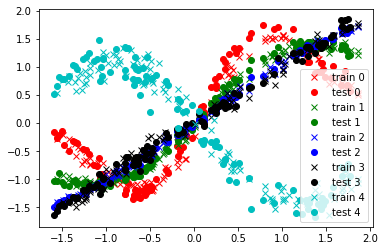

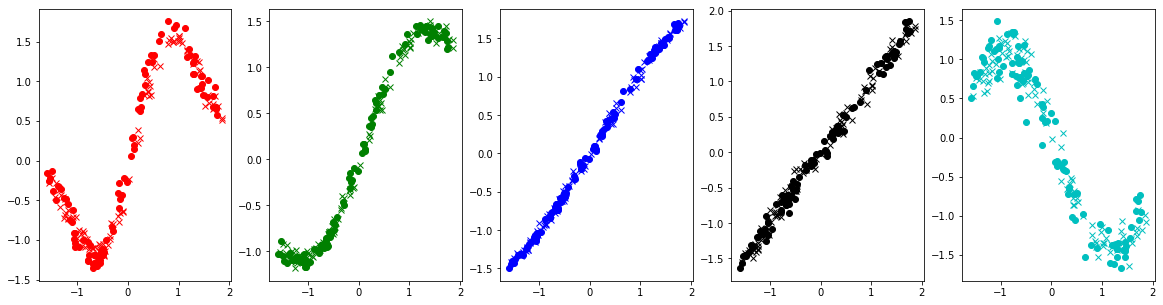

In [170]:
nonstat_regression_plot()

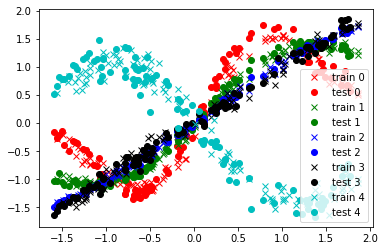

In [165]:
X_train, y_train, X_test, y_test, task_id_train, task_id_test = make_1d_regression_sequence(n_dist=5)
ntasks = len(np.unique(task_id_train))
colors = ['r', 'g', 'b', 'k', 'c']
plt.figure()
for i in range(ntasks):
    ndx_train = (task_id_train == i)
    plt.plot(X_train[ndx_train], y_train[ndx_train], 'x', color=colors[i], label='train {:d}'.format(i))
    ndx_test = (task_id_test == i)
    plt.plot(X_test[ndx_test], y_test[ndx_test], 'o', color=colors[i], label='test {:d}'.format(i))
plt.legend()



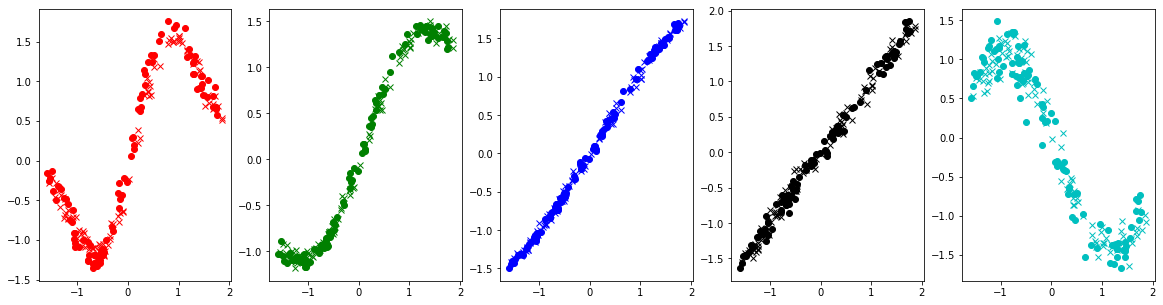

In [167]:

ntasks = len(np.unique(task_id_train))
colors = ['r', 'g', 'b', 'k', 'c']
fig, axs = plt.subplots(1,ntasks, figsize=(20,5))
for i in range(ntasks):
    ax = axs[i]
    ndx_train = (task_id_train == i)
    ax.plot(X_train[ndx_train], y_train[ndx_train], 'x', color=colors[i], label='train {:d}'.format(i))
    ndx_test = (task_id_test == i)
    ax.plot(X_test[ndx_test], y_test[ndx_test], 'o', color=colors[i], label='test {:d}'.format(i))
#plt.legend()

In [ ]:
X_train = jnp.hstack(X_train[:,:,0])
X_test = jnp.hstack(X_test[:,:,0])
y_train = jnp.hstack(y_train[:,:,0])
y_test = jnp.hstack(y_test[:,:,0])
print(X_train.shape, X_test.shape)